In [18]:
import pandas as pd
import geopandas as gpd
import tensorflow as tf
# import teller as tr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sns
import missingno as msno
# import pyarrow as pa
# import pyarrow.parquet as pq
import numpy as np

In [19]:
# !pip install tensorflow
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install missingno

In [20]:

path = './nowa_gwiazdka.geojson'
df_p = gpd.read_file(path)


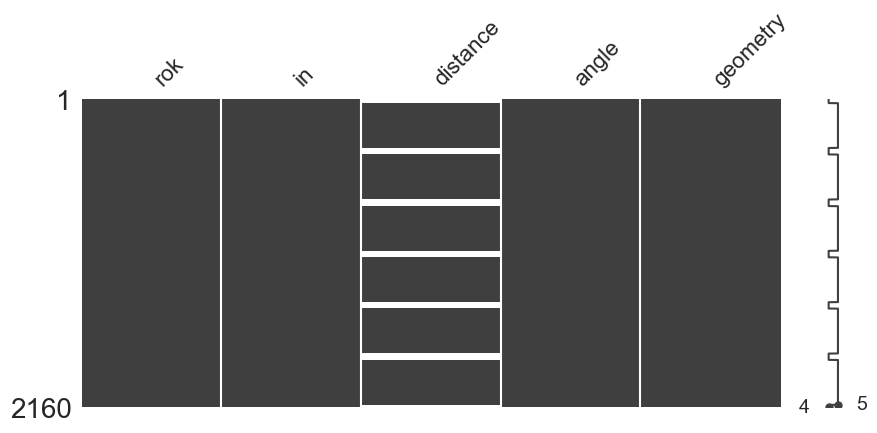

In [21]:
msno.matrix(df_p, figsize=(10,4)) # test pustych wierszy
df_p =df_p.fillna(0) # wypełnianie Nan zerami


In [22]:
df_p.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rok,2160.0,2016.833333,3.891773,2011.0,2013.000000,2017.500000,2020.000000,2022.00000
distance,2160.0,136.078593,65.631859,0.0,119.364434,139.242487,174.674532,299.73138
angle,2160.0,179.500000,103.946712,0.0,89.750000,179.500000,269.250000,359.00000


In [23]:
df_p.head()

,rok,in,distance,angle,geometry
0,2011,True,0.0,0,"LINESTRING (7527541.11000 5863838.87000, 75275..."
1,2011,True,0.0,1,"LINESTRING (7527541.11000 5863838.87000, 75275..."
2,2011,True,0.0,2,"LINESTRING (7527541.11000 5863838.87000, 75275..."
3,2011,True,0.0,3,"LINESTRING (7527541.11000 5863838.87000, 75275..."
4,2011,True,0.0,4,"LINESTRING (7527541.11000 5863838.87000, 75275..."


In [24]:
df_p.shape


(2160, 5)

In [25]:
#normalizacja i podzial na dane wejsciowe i wyjsciowe
X = df_p[["rok", 'in', 'angle']]
X = MinMaxScaler().fit_transform(X)
y = df_p['distance']
X.shape, y.shape

((2160, 3), (2160,))

In [26]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     # random_state=42,
                                                     test_size=.4)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1296, 3), (864, 3), (1296,), (864,))

# MODEL

In [28]:
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate,Dropout,CategoryEncoding, Embedding, Flatten,Conv2D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.random import set_seed #ustawiam ziarno pseudolosowości
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime as dt
import os

In [29]:
N_TRAIN = int(1e4)
BATCH_SIZE = 16
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

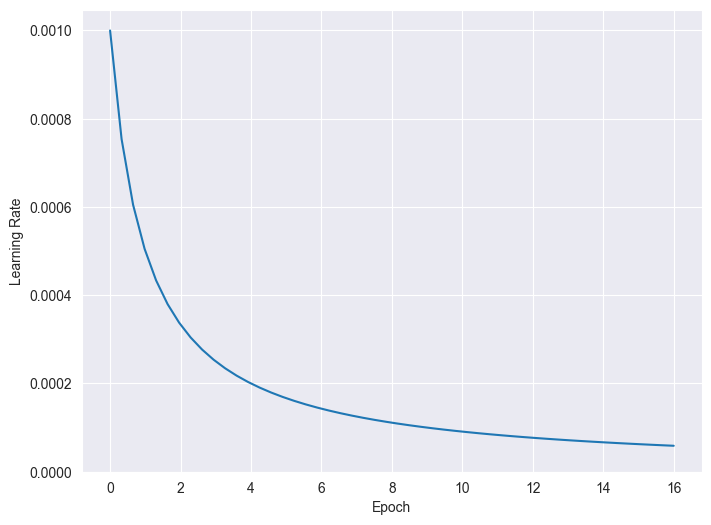

In [30]:
step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [31]:
from keras import regularizers


def create_ANN():
    set_seed(0)
    model = Sequential()
    model.add(
        Dense(3, activation='relu',
              kernel_regularizer=regularizers.l2(0.001), #opcja
              kernel_initializer='he_uniform')
    )
    model.add(Dropout(0.5))
    # model.add(Dense(32, activation='relu'))
    model.add(
        Dense(1, activation='relu',
              kernel_regularizer=regularizers.l2(0.001))# opcja
    )

    model.compile(
        loss='mae',
        optimizer=get_optimizer(),
        metrics=['mae','mse'])

    return model

In [32]:
_filepath = 'checkpoint/ann-{epoch:02d}-{loss:.3f}.h5' # for filepath
checkpoint = ModelCheckpoint(monitor='loss', filepath='checkpoint/_best-ann.h5', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='loss', patience=3, min_delta=0.01, verbose=1)
tb = TensorBoard(log_dir='logs/'+dt.now().strftime("%Y%m%d-%H%M%S")) # logi tensor board

In [33]:
model = create_ANN()

result = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    validation_split=.3,
    callbacks=[checkpoint,es,tb],
    verbose=0,
)


Epoch 1: loss improved from inf to 140.92451, saving model to checkpoint\_best-ann.h5


C:\Users\patry\Desktop\ai_river_project\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: loss improved from 140.92451 to 140.92366, saving model to checkpoint\_best-ann.h5

Epoch 3: loss improved from 140.92366 to 140.92293, saving model to checkpoint\_best-ann.h5

Epoch 4: loss improved from 140.92293 to 140.92235, saving model to checkpoint\_best-ann.h5
Epoch 4: early stopping


In [34]:
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 3)                 12        
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 16 (64.00 Byte)
Trainable params: 16 (64.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


AttributeError: module 'pydot' has no attribute 'InvocationException'

In [ ]:
# evaluate the keras model
loss,  mae , mse = model.evaluate(X_test, y_test)
print(f'loss:{loss}, \nmse: {mse}')

In [ ]:
df_results = pd.DataFrame(result.history)
df_results.plot(figsize=(10,10))
plt.title('Wykres zbiorczy błędów uczenia w kolejnych epokach')
plt.xlabel('Epoka')

In [ ]:
df_results

In [ ]:
y_predicted = model.predict(X_test)

In [ ]:
df__a = pd.DataFrame(y_test)
df__a['y_predicted']=y_predicted
df__a['diff']=df__a.y_predicted-df__a.distance
df__a['abs_diff'] = abs(df__a['diff'])
df__a['diff_pow']=df__a['diff']*df__a['diff']
df__a.tail()

In [ ]:
import math
mean_ref = df__a['distance'].describe()[1]
bias = df__a['diff'].describe()[1]
mae =df__a['abs_diff'].describe()[1]
RMSE = math.sqrt(df__a['diff_pow'].sum()/df__a.shape[0])
print(
    f'mean_ref: {mean_ref},'
    f'\nbias: {bias}, \nbias_%: {bias/mean_ref*100}, '
    f'\nmae: {mae}, \nmae_%: {mae/mean_ref*100}, '
    f'\nRMSE: {RMSE} \nRMSE %: {RMSE/mean_ref*100}'
)

In [ ]:
# rozkład błedów
error = df__a.y_predicted-df__a.distance
plt.figure(figsize = (6,6))
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [ ]:
plt.figure(figsize = (8,8))
df__a.plot.scatter(y='y_predicted', x='distance')
plt.plot(range(5), color='orange')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('y_ref')
plt.ylabel('y_pred')
plt.draw()